<a href="https://www.kaggle.com/code/bavan2005/oral-cancer-detection?scriptVersionId=280038506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **proposed convnext model**

**steps to run proposed model**


1.  **install dependenciesstep**
2.  **run initialise proposed modelstep**
3.  **run** 




**step 1**

In [1]:
!pip install timm -q
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q

# ✅ ADD THIS LINE AT THE END
!pip install numpy==1.26.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

**step 2**

In [9]:

%%writefile train_oral_cancer.py

# --- 1. Imports ---
print("Importing libraries...")
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import shutil
import time
import argparse
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm # For ConvNeXt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

# For Grad-CAM
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image
    GRAD_CAM_AVAILABLE = True
    print("pytorch-grad-cam imported successfully.")
except ImportError:
    print("Warning: pytorch-grad-cam not found. Grad-CAM will be skipped.")
    GRAD_CAM_AVAILABLE = False

import warnings
warnings.filterwarnings("ignore")


# --- 2. Configuration ---
print("Setting up configuration...")

# ✅ This matches your folder structure
DATA_DIRS = {
    'non-cancerous': '/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER',
    'cancerous': '/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER',
}

CONFIG = {
    "OUTPUT_DIR": "/kaggle/working/",
    
    # Model choice: 'convnext_base.fb_in22k_ft_in1k', 'resnet50', 'vgg16', 'mobilenetv3_large_100'
    "MODEL_NAME": "convnext_base.fb_in22k_ft_in1k", # Default, can be overridden by --model
    "IMG_SIZE": 224,
    "BATCH_SIZE": 32,
    "EPOCHS_FROZEN": 15,
    "EPOCHS_FINETUNE": 25,
    "LR_FROZEN": 1e-3,
    "LR_FINETUNE": 1e-5,
    "SEED": 42,
    "NUM_WORKERS": os.cpu_count(),
    "TEST_SPLIT_SIZE": 0.15, # 15% for final test set
    "VALID_SPLIT_SIZE": 0.2, # 20% of the remainder for validation (0.2 * 0.85 = 17%)
    "PATIENCE_EARLY_STOPPING": 7,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["SEED"])
print(f"Using device: {CONFIG['DEVICE']}")


# --- 3. Load Data, Balance, & Expand (CORRECTED LOGIC) ---
def load_and_prepare_data(data_dirs, config):
    print("--- 3.1: Discovering image files ---")
    filepaths = []
    labels = []
    for label, path in data_dirs.items():
        image_files = glob(os.path.join(path, '**', '*.jpg'), recursive=True) + \
                      glob(os.path.join(path, '**', '*.jpeg'), recursive=True) + \
                      glob(os.path.join(path, '**', '*.png'), recursive=True)
        
        image_files = [f for f in image_files if not os.path.basename(f).startswith('._')]
        
        filepaths.extend(image_files)
        labels.extend([label] * len(image_files))
        print(f"Found {len(image_files)} images for class: {label}")

    df_full = pd.DataFrame({'filepath': filepaths, 'label': labels})
    print(f"\nOriginal full dataset shape: {df_full.shape}")
    print("Original class distribution:\n", df_full['label'].value_counts())

    if df_full.empty:
        raise ValueError("No images found. Check your DATA_DIRS paths.")

    # --- 3.2: Data Balancing ---
    print("\n--- 3.2: Applying Data Balancing ---")
    class_counts = df_full['label'].value_counts()
    K = int(round(class_counts.values.mean())) # Target K is the mean
    print(f"Target K (mean images per class, rounded): {K}")

    balanced_dfs_list = []
    for class_label, count in class_counts.items():
        class_df = df_full[df_full['label'] == class_label]
        if count < K:
            num_to_add = K - count
            print(f"Class '{class_label}': Oversampling by duplicating {num_to_add} samples.")
            additional_samples = class_df.sample(n=num_to_add, replace=True, random_state=config["SEED"])
            balanced_dfs_list.append(pd.concat([class_df, additional_samples]))
        else: # count >= K
            print(f"Class '{class_label}': Undersampling to {K} samples.")
            downsampled_df = class_df.sample(n=K, replace=False, random_state=config["SEED"])
            balanced_dfs_list.append(downsampled_df)

    df_balanced = pd.concat(balanced_dfs_list).reset_index(drop=True)
    print(f"Total images after balancing: {len(df_balanced)}")

    # --- 3.3: Label Encoding ---
    print("\n--- 3.3: Encoding Labels ---")
    label_encoder = LabelEncoder()
    df_balanced['label_encoded'] = label_encoder.fit_transform(df_balanced['label'])
    CLASSES = label_encoder.classes_.tolist()
    NUM_CLASSES = len(CLASSES)
    print(f"Classes: {CLASSES} (Count: {NUM_CLASSES})")
    
    # --- 3.4: Split Data *BEFORE* Expansion (FIXES LEAKAGE) ---
    
    print("\n--- 3.4: Splitting Data (BEFORE expansion) ---")
    # First, split off the test set (15%)
    train_val_df, test_df = train_test_split(
        df_balanced,
        test_size=config["TEST_SPLIT_SIZE"],
        random_state=config["SEED"],
        stratify=df_balanced['label_encoded']
    )
    
    # Then, split the remainder into train and validation (20% of the 85%)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=config["VALID_SPLIT_SIZE"],
        random_state=config["SEED"],
        stratify=train_val_df['label_encoded']
    )
    print(f"Original split: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")

    # --- 3.5: Expand *ONLY* the Training Set ---
    print("\n--- 3.5: Applying 4x Expansion to *Training Set* ONLY ---")
    df_original = train_df.copy(); df_original['apply_flip'] = False; df_original['apply_mask'] = False
    df_flipped = train_df.copy(); df_flipped['apply_flip'] = True; df_flipped['apply_mask'] = False
    df_masked_original = train_df.copy(); df_masked_original['apply_flip'] = False; df_masked_original['apply_mask'] = True
    df_masked_flipped = train_df.copy(); df_masked_flipped['apply_flip'] = True; df_masked_flipped['apply_mask'] = True
    
    train_df_expanded = pd.concat([df_original, df_flipped, df_masked_original, df_masked_flipped], ignore_index=True)
    
    # --- 3.6: Prepare Validation and Test Sets (No Expansion) ---
    # Add the augmentation flag columns, but set them to False
    print("Preparing validation and test sets (no expansion)...")
    val_df['apply_flip'] = False
    val_df['apply_mask'] = False
    test_df['apply_flip'] = False
    test_df['apply_mask'] = False

    # --- 3.7: Final Shuffling of Training Set ---
    train_df_final = train_df_expanded.sample(frac=1, random_state=config["SEED"]).reset_index(drop=True)
    
    # Reset index for val and test
    val_df_final = val_df.reset_index(drop=True)
    test_df_final = test_df.reset_index(drop=True)
    
    print(f"\nFinal training data shape (expanded): {train_df_final.shape}")
    print(f"Final validation data shape (original): {val_df_final.shape}")
    print(f"Final test data shape (original): {test_df_final.shape}")

    return train_df_final, val_df_final, test_df_final, CLASSES, NUM_CLASSES, label_encoder


# --- 4. Preprocessing & Augmentation ---
class CircularMask:
    """Applies a circular mask to a PIL Image, blacking out the corners."""
    def __call__(self, img):
        width, height = img.size
        mask = Image.new('L', (width, height), 0)
        draw = ImageDraw.Draw(mask)
        diameter = min(width, height)
        x0 = (width - diameter) / 2
        y0 = (height - diameter) / 2
        x1 = x0 + diameter
        y1 = y0 + diameter
        draw.ellipse((x0, y0, x1, y1), fill=255)

        img_masked = Image.new('RGB', (width, height), (0, 0, 0))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_masked.paste(img, (0,0), mask)
        return img_masked

def get_transforms(model_name, img_size):
    print("--- 4: Defining Transforms ---")
    # Get model-specific normalization
    data_config = timm.data.resolve_data_config({}, model=timm.create_model(model_name, pretrained=False))
    IMG_MEAN = data_config['mean']
    IMG_STD = data_config['std']
    print(f"Using model-specific normalization: mean={IMG_MEAN}, std={IMG_STD}")

    train_transforms = transforms.Compose([
        # Note: Mask/flip are handled conditionally in the Dataset class
        transforms.Resize((img_size + 32, img_size + 32)),
        transforms.RandomCrop(img_size),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10, scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    ])

    val_test_transforms = transforms.Compose([
        # Val/Test: Mask is applied *conditionally* in the Dataset class
        # (but for these sets, the 'apply_mask' flag will always be False)
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    ])
    
    # Special preprocessor for Grad-CAM that *always* applies the mask
    preprocess_for_gradcam = transforms.Compose([
        CircularMask(),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
    ])
    
    return train_transforms, val_test_transforms, preprocess_for_gradcam


# --- 5. Dataset & DataLoaders ---
class OralCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df # Already has reset index from prep function
        self.transform = transform
        
        self.filepaths = self.df['filepath'].values
        self.labels = self.df['label_encoded'].values
        
        # Get flags for conditional augmentation from the dataframe
        self.apply_flip_flags = self.df['apply_flip'].values
        self.apply_mask_flags = self.df['apply_mask'].values
        self.circular_mask_processor = CircularMask()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"ERROR loading {img_path}: {e}. Returning placeholder.")
            image = Image.new('RGB', (CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]), color = 'red')
            return self.transform(image), torch.tensor(-1, dtype=torch.long) # Error flag

        # Apply conditional augmentations (PIL ops)
        if self.apply_mask_flags[idx]:
            image = self.circular_mask_processor(image)
        if self.apply_flip_flags[idx]:
            image = transforms.functional.hflip(image)

        # Apply main augmentation pipeline (Tensor ops)
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


# --- 6. Model Definition ---
def get_model(model_name, num_classes, pretrained=True, freeze_backbone=True):
    print(f"--- 6: Defining Model ({model_name}) ---")
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the classifier head
        for param in model.get_classifier().parameters():
            param.requires_grad = True
        print(f"Froze backbone. Training only classifier: {model.default_cfg['classifier']}")
    return model

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True
    print("Unfroze all layers for fine-tuning.")


# --- 7. Training Loop ---
def train_one_epoch(model, loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        if (labels == -1).any(): continue # Skip error batches
            
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        if scheduler and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        if total_samples > 0:
            acc_so_far = correct_predictions / total_samples
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc_so_far:.4f}")

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating")
        for images, labels in pbar:
            if (labels == -1).any(): continue

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            if total_samples > 0:
                acc_so_far = correct_predictions / total_samples
                pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc_so_far:.4f}")

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc


# --- 8. Plot Training History ---
def plot_training_curves_seaborn(history_dict):
    print("--- 8: Plotting Training Curves ---")
    epochs_ran = len(history_dict['train_loss'])
    if epochs_ran == 0:
        print("No training history to plot.")
        return
        
    epochs_axis = range(1, epochs_ran + 1)
    
    df_plot = pd.DataFrame({
        'epoch': list(epochs_axis) * 4,
        'value': history_dict['train_acc'] + history_dict['val_acc'] + history_dict['train_loss'] + history_dict['val_loss'],
        'metric_type': (['Accuracy'] * (epochs_ran * 2)) + (['Loss'] * (epochs_ran * 2)),
        'dataset': (['Train'] * epochs_ran + ['Validation'] * epochs_ran) * 2
    })
    
    plt.figure(figsize=(18, 7))
    sns.set_style("whitegrid")
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df_plot[df_plot.metric_type == 'Accuracy'], x='epoch', y='value', hue='dataset', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df_plot[df_plot.metric_type == 'Loss'], x='epoch', y='value', hue='dataset', marker='o')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG["OUTPUT_DIR"], "training_curves.png"))
    plt.show()


# --- 9. Final Evaluation on Test Set ---
def final_evaluation(model, best_model_path, test_loader, device, class_names):
    print("--- 9: Final Evaluation on Test Set ---")
    # Load best model
    if os.path.exists(best_model_path):
        print(f"Loading best model for final evaluation: {best_model_path}")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    else:
        print("Warning: Best model not found. Using current model state.")
        
    model.eval()
    all_test_preds = []
    all_test_labels = []

    print("Generating predictions on the held-out test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            if (labels == -1).any(): continue
            images = images.to(device)
            
            outputs = model(images)
            _, predicted_indices = torch.max(outputs, 1)

            all_test_preds.extend(predicted_indices.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    if all_test_labels and all_test_preds:
        print("\n--- Test Set Classification Report ---")
        # This report includes Precision, Recall, and F1-Score
        report = classification_report(all_test_labels, all_test_preds, target_names=class_names, digits=4)
        print(report)
        
        # Save report to file
        with open(os.path.join(CONFIG["OUTPUT_DIR"], "classification_report.txt"), "w") as f:
            f.write(report)

        print("\nPlotting Confusion Matrix for Test Set:")
        cm = confusion_matrix(all_test_labels, all_test_preds)
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
        plt.title('Confusion Matrix on Test Set', fontsize=16)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(CONFIG["OUTPUT_DIR"], "confusion_matrix.png"))
        plt.show()
    else:
        print("No test predictions generated.")


# --- 10. Grad-CAM Visualization ---
def run_grad_cam(model, df_subset, device, class_names_list, grad_cam_preprocessor, num_images=6):
    if not GRAD_CAM_AVAILABLE:
        print("--- 10: Grad-CAM skipped (library not available) ---")
        return
        
    print("\n--- 10: Running Grad-CAM visualization ---")
    
    # Find the last convolutional-like block in ConvNeXt
    target_layer_found = False
    # Check for ConvNeXt 'stages'
    if hasattr(model, 'stages') and isinstance(model.stages, nn.Sequential) and len(model.stages) > 0:
        target_layers_for_grad_cam = [model.stages[-1]]
        target_layer_found = True
    # Check for ResNet-like 'layer4'
    elif hasattr(model, 'layer4') and isinstance(model.layer4, nn.Sequential) and len(model.layer4) > 0:
        target_layers_for_grad_cam = [model.layer4[-1]]
        target_layer_found = True
    # Check for VGG-like 'features'
    elif hasattr(model, 'features') and isinstance(model.features, nn.Sequential) and len(model.features) > 0:
        # Find the last Conv2d layer in VGG
        for layer in reversed(model.features):
            if isinstance(layer, nn.Conv2d):
                target_layers_for_grad_cam = [layer]
                target_layer_found = True
                break
    
    if not target_layer_found:
        print(f"Could not automatically find target layer for {CONFIG['MODEL_NAME']}. Grad-CAM skipped.")
        return
    else:
        print(f"Using target layer for Grad-CAM: {target_layers_for_grad_cam[0].__class__.__name__}")

    grad_cam_instance = GradCAM(model=model, target_layers=target_layers_for_grad_cam)

    if df_subset.empty:
        print("DataFrame for visualization is empty.")
        return

    samples = df_subset.sample(min(num_images, len(df_subset)), random_state=CONFIG["SEED"])
    num_cols = 4 # Original, Masked Input, Grad-CAM Overlay, Heatmap
    num_rows = len(samples)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5.5 * num_rows))
    if num_rows == 1: axes = axes.reshape(1, -1)

    model.eval()

    for idx, (_, row) in enumerate(samples.iterrows()):
        image_path = row['filepath']
        true_label_idx = row['label_encoded']
        ax_row = axes[idx]
        
        try:
            original_pil = Image.open(image_path).convert('RGB')
            # Use the special Grad-CAM preprocessor (always applies mask)
            input_tensor = grad_cam_preprocessor(original_pil.copy()).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(input_tensor)
            pred_idx = torch.max(outputs, 1)[1].item()
            
            cam_targets = [ClassifierOutputTarget(pred_idx)]
            grayscale_cam = grad_cam_instance(input_tensor=input_tensor, targets=cam_targets)[0, :]
            
            # Prepare display image (masked input)
            display_pil = CircularMask()(original_pil.copy()).resize((CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]))
            display_np = np.array(display_pil) / 255.0
            
            cam_viz = show_cam_on_image(display_np, grayscale_cam, use_rgb=True, image_weight=0.5)

            true_class_name = class_names_list[true_label_idx]
            pred_class_name = class_names_list[pred_idx]
            title_color = 'green' if true_class_name == pred_class_name else 'red'
            
            # Plotting
            ax_row[0].imshow(original_pil.resize((CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"])))
            ax_row[0].set_title(f'Original\nTrue: {true_class_name}', fontsize=12)
            
            ax_row[1].imshow(display_np)
            ax_row[1].set_title(f'Masked Input\nPred: {pred_class_name}', fontsize=12, color=title_color)
            
            ax_row[2].imshow(cam_viz)
            ax_row[2].set_title('Grad-CAM Overlay', fontsize=12)
            
            ax_row[3].imshow(grayscale_cam, cmap='jet')
            ax_row[3].set_title('Heatmap Only', fontsize=12)
            
            for ax in ax_row: ax.axis('off')

        except Exception as e:
            print(f"ERROR processing image {image_path}: {e}")
            ax_row[0].text(0.5, 0.5, 'Error loading image', ha='center', va='center')

    plt.tight_layout(pad=1.5, h_pad=2.5)
    plt.savefig(os.path.join(CONFIG["OUTPUT_DIR"], "grad_cam_visualization.png"))
    plt.show()


# --- 11. Main Execution ---
def main(args):
    # Override config with args
    CONFIG["MODEL_NAME"] = args.model
    CONFIG["EPOCHS_FROZEN"] = args.epochs_frozen
    CONFIG["EPOCHS_FINETUNE"] = args.epochs_finetune
    
    print(f"--- 11.1: Starting Main Execution ---")
    print(f"Selected model: {CONFIG['MODEL_NAME']}")
    
    # 1. Load and prepare data
    train_df, val_df, test_df, CLASSES, NUM_CLASSES, _ = load_and_prepare_data(DATA_DIRS, CONFIG)
    
    # 2. Get transforms
    train_transforms, val_test_transforms, grad_cam_preprocessor = get_transforms(CONFIG["MODEL_NAME"], CONFIG["IMG_SIZE"])
    
    # 3. Create Datasets and DataLoaders
    print("\n--- 5: Creating Datasets and DataLoaders ---")
    train_dataset = OralCancerDataset(train_df, transform=train_transforms)
    val_dataset = OralCancerDataset(val_df, transform=val_test_transforms)
    test_dataset = OralCancerDataset(test_df, transform=val_test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=CONFIG["NUM_WORKERS"], pin_memory=True)
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

    # 4. Get model
    model = get_model(CONFIG["MODEL_NAME"], NUM_CLASSES, pretrained=True, freeze_backbone=True)
    model = model.to(CONFIG["DEVICE"])
    
    criterion = nn.CrossEntropyLoss()
    history_log = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    best_val_acc = 0.0
    best_model_path = os.path.join(CONFIG["OUTPUT_DIR"], f"best_{CONFIG['MODEL_NAME'].replace('.', '_')}.pth")
    epochs_without_improvement = 0

    # 5. --- Phase 1: Training with Frozen Backbone ---
    print("\n--- 7.1: Phase 1: Training with Frozen Backbone ---")
    optimizer_frozen = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CONFIG["LR_FROZEN"])
    scheduler_frozen = optim.lr_scheduler.ReduceLROnPlateau(optimizer_frozen, mode='max', factor=0.2, patience=3, verbose=True)

    for epoch in range(CONFIG["EPOCHS_FROZEN"]):
        epoch_time_start = time.time()
        print(f"Epoch {epoch+1}/{CONFIG['EPOCHS_FROZEN']} (Frozen)")
        current_lr = optimizer_frozen.param_groups[0]['lr']
        history_log['lr'].append(current_lr)

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer_frozen, CONFIG["DEVICE"])
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, CONFIG["DEVICE"])
        
        history_log['train_loss'].append(train_loss); history_log['train_acc'].append(train_acc)
        history_log['val_loss'].append(val_loss); history_log['val_acc'].append(val_acc)
        
        epoch_time_end = time.time()
        print(f"Time: {epoch_time_end - epoch_time_start:.2f}s - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        
        scheduler_frozen.step(val_acc)
        
        if val_acc > best_val_acc:
            print(f"Val Acc improved ({best_val_acc:.4f} --> {val_acc:.4f}). Saving model...")
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= CONFIG["PATIENCE_EARLY_STOPPING"]:
            print(f"Early stopping triggered after {epoch+1} epochs (frozen phase).")
            break

    # 6. --- Phase 2: Fine-tuning Full Model ---
    if not os.path.exists(best_model_path):
        print("Warning: No best model from frozen phase. Saving current model.")
        torch.save(model.state_dict(), best_model_path)
        best_val_acc = val_acc # Use the last val_acc as the baseline
        
    print(f"\nLoading best model from frozen phase: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
        
    print("\n--- 7.2: Phase 2: Fine-tuning Full Model ---")
    unfreeze_model(model)
    optimizer_finetune = optim.AdamW(model.parameters(), lr=CONFIG["LR_FINETUNE"])
    scheduler_finetune = optim.lr_scheduler.ReduceLROnPlateau(optimizer_finetune, mode='max', factor=0.2, patience=3, verbose=True)
    epochs_without_improvement = 0 # Reset for fine-tuning

    for epoch in range(CONFIG["EPOCHS_FINETUNE"]):
        epoch_time_start = time.time()
        print(f"Epoch {epoch+1}/{CONFIG['EPOCHS_FINETUNE']} (Fine-tuning)")
        current_lr = optimizer_finetune.param_groups[0]['lr']
        history_log['lr'].append(current_lr)

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer_finetune, CONFIG["DEVICE"])
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, CONFIG["DEVICE"])
        
        history_log['train_loss'].append(train_loss); history_log['train_acc'].append(train_acc)
        history_log['val_loss'].append(val_loss); history_log['val_acc'].append(val_acc)

        epoch_time_end = time.time()
        print(f"Time: {epoch_time_end - epoch_time_start:.2f}s - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler_finetune.step(val_acc)

        if val_acc > best_val_acc:
            print(f"Val Acc improved ({best_val_acc:.4f} --> {val_acc:.4f}). Saving model...")
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= CONFIG["PATIENCE_EARLY_STOPPING"]:
            print(f"Early stopping triggered after {epoch+1} epochs (fine-tuning phase).")
            break

    print("\nTraining complete.")
    print(f"Best validation accuracy achieved: {best_val_acc:.4f}")
    
    # 7. Plot History
    plot_training_curves_seaborn(history_log)
    
    # 8. Final Evaluation
    final_evaluation(model, best_model_path, test_loader, CONFIG["DEVICE"], CLASSES)
    
    # 9. Grad-CAM
    # Run visualization on a few images from the validation set
    run_grad_cam(model, val_df, CONFIG["DEVICE"], CLASSES, grad_cam_preprocessor)
    
    print("\n--- End of Script ---")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train Oral Cancer Detection Model")
    parser.add_argument(
        "--model", 
        type=str, 
        default=CONFIG["MODEL_NAME"], 
        help=f"Model name from timm. Default: {CONFIG['MODEL_NAME']}"
    )
    parser.add_argument(
        "--epochs_frozen", 
        type=int, 
        default=CONFIG["EPOCHS_FROZEN"], 
        help="Epochs for frozen phase"
    )
    parser.add_argument(
        "--epochs_finetune", 
        type=int, 
        default=CONFIG["EPOCHS_FINETUNE"], 
        help="Epochs for fine-tuning phase"
    )
    # In a notebook, args might be empty, so we handle that
    if 'ipykernel' in str(globals().get('__name__', '')):
        # We are in a notebook, use default CONFIG
        print("Running in notebook environment, using default CONFIG.")
        args = parser.parse_args(args=[])
    else:
        # We are in a script, parse command-line args
        print("Running as script, parsing command-line args.")
        args = parser.parse_args()

    main(args)

Overwriting train_oral_cancer.py


**step 3**

In [10]:
!python3 train_oral_cancer.py

Importing libraries...
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type 

**to run specific images**

In [ ]:
IMAGE_PATH = '/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/002.jpeg'
result = predict_image(IMAGE_PATH, model, preprocess, DEVICE)
visualize_prediction(IMAGE_PATH, result)

# **run all above 3 step**

**comparision models**

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6142 - loss: 10.7680 - precision_2: 0.5804 - recall_2: 0.6751
Epoch 1: val_accuracy improved from -inf to 0.46277, saving model to /kaggle/working/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.6162 - loss: 10.7502 - precision_2: 0.5829 - recall_2: 0.6754 - val_accuracy: 0.4628 - val_loss: 215.4824 - val_precision_2: 0.4599 - val_recall_2: 1.0000 - learning_rate: 0.0010
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7340 - loss: 8.0578 - precision_2: 0.7238 - recall_2: 0.7212
Epoch 2: val_accuracy improved from 0.46277 to 0.46809, saving model to /kaggle/working/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7345 - loss: 8.0048 - precision_2: 0.7246 - recall_2: 0.7217 - val_accuracy: 0.4681 - val_loss: 41.0994 - val_precision_2: 0.4615 - val_recall_2: 0.9767 - learning_rate: 0.0010
Epoch 3/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7461 - l

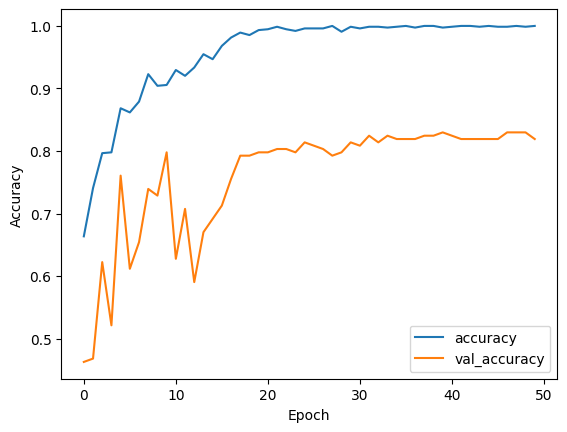

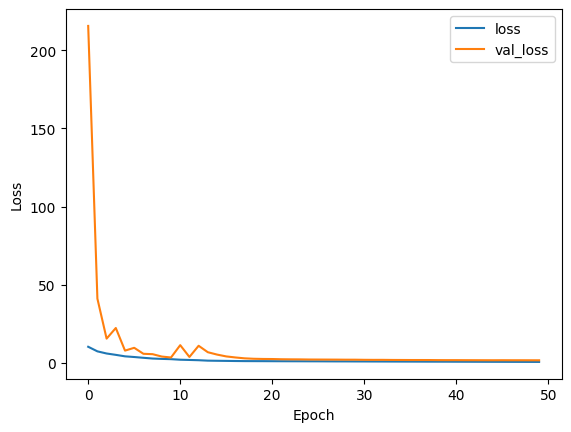


--- Loading best model from checkpoint ---

--- Evaluating model on test data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8366 - loss: 1.5600 - precision_2: 0.8348 - recall_2: 0.7821
Test Loss: 1.7696
Test Accuracy: 0.8298
Test Precision: 0.8375
Test Recall: 0.7791
Test F1 Score (for Class 1 'non cancer'): 0.8072

--- Generating Classification Report and Confusion Matrix ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

--- Classification Report (Scikit-learn) ---
                      precision    recall  f1-score   support

    cancer (Class 0)       0.82      0.87      0.85       102
non cancer (Class 1)       0.84      0.78      0.81        86

            accuracy                           0.83       188
           macro avg       0.83      0.83      0.83       188
        weighted avg       0.83      0.83      0.83       188


--- Confusion Matrix ---


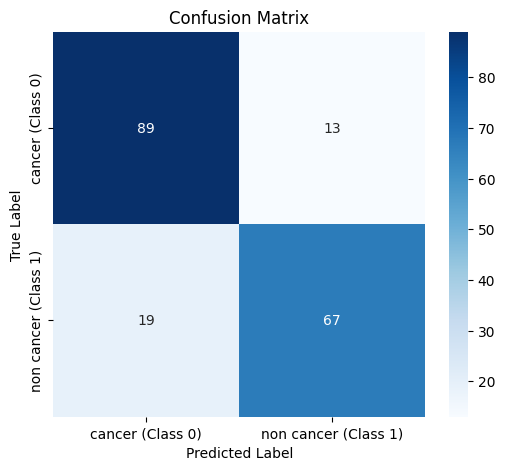

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load data
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(128, 128))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Define and compile the model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

# Train the model
history = model.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- 🧪 Model Evaluation and F1 Score ---

print("\n--- Loading best model from checkpoint ---")
# Load the weights from the best model saved during training
model.load_weights(checkpoint_filepath)

print("\n--- Evaluating model on test data ---")
# Evaluate the model on the test set
# The 'evaluation' list will contain [loss, accuracy, precision, recall]
evaluation = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")

# Calculate F1 Score from Keras metrics
# NOTE: Keras's default metrics (Precision, Recall) are for class 1.
# In your case (enumerate(['cancer', 'non cancer'])), 
# Class 0 = 'cancer' and Class 1 = 'non cancer'.
# So, this F1 score is for the 'non cancer' class.
precision = evaluation[2]
recall = evaluation[3]
f1_score_keras = 2 * (precision * recall) / (precision + recall + 1e-7) # Add 1e-7 to avoid division by zero
print(f"Test F1 Score (for Class 1 'non cancer'): {f1_score_keras:.4f}")


print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions for the test set
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Define target names based on your load_data function
# 0 = 'cancer', 1 = 'non cancer'
target_names = ['cancer (Class 0)', 'non cancer (Class 1)']

print("\n--- Classification Report (Scikit-learn) ---")
# This report shows precision, recall, and F1-score for EACH class
print(classification_report(y_test, y_pred_binary, target_names=target_names))


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# reference

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5127 - loss: 12.0841 - precision_3: 0.5100 - recall_3: 0.4533
Epoch 1: val_accuracy improved from -inf to 0.44681, saving model to /kaggle/working/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.5138 - loss: 12.0799 - precision_3: 0.5105 - recall_3: 0.4551 - val_accuracy: 0.4468 - val_loss: 24.1231 - val_precision_3: 0.4308 - val_recall_3: 0.6512 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6169 - loss: 9.6592 - precision_3: 0.5985 - recall_3: 0.5682
Epoch 2: val_accuracy improved from 0.44681 to 0.60106, saving model to /kaggle/working/best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6168 - loss: 9.6855 - precision_3: 0.5985 - recall_3: 0.5706 - val_accuracy: 0.6011 - val_loss: 20.0703 - val_precision_3: 0.8235 - val_recall_3: 0.1628 - learning_rate: 0.0010
Epoch 3/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6654 - lo

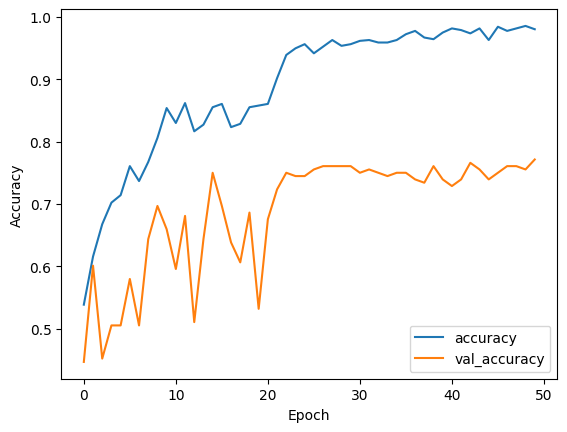

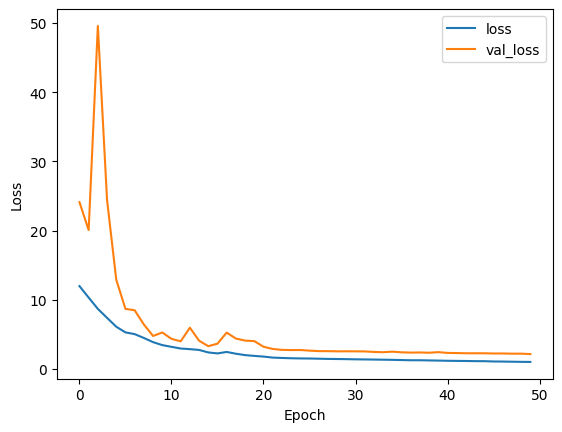


--- Loading best model from checkpoint ---

--- Evaluating model on test data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7751 - loss: 1.9170 - precision_3: 0.7773 - recall_3: 0.6855
Test Loss: 2.1514
Test Accuracy: 0.7713
Test Precision: 0.7867
Test Recall: 0.6860
Test F1 Score (for Class 1 'non cancer'): 0.7329

--- Generating Classification Report and Confusion Matrix ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step

--- Classification Report (Scikit-learn) ---
                      precision    recall  f1-score   support

    cancer (Class 0)       0.76      0.84      0.80       102
non cancer (Class 1)       0.79      0.69      0.73        86

            accuracy                           0.77       188
           macro avg       0.77      0.76      0.77       188
        weighted avg       0.77      0.77      0.77       188


--- Confusion Matrix ---


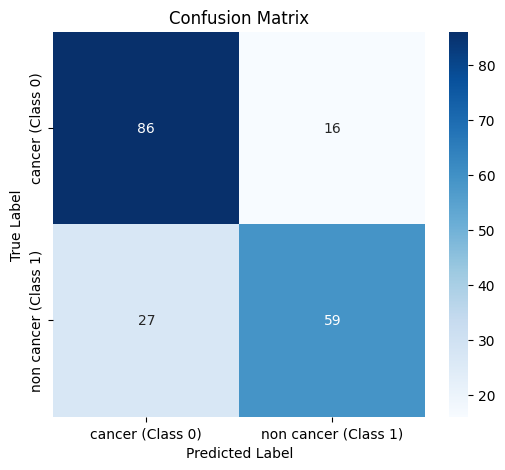

In [6]:
# --- 1. Imports ---
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Imports needed for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 2. Load Data with Augmentation ---
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(128, 128))  # Adjust target size as needed
            
            # Data augmentation
            image = img_to_array(image)
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.random_brightness(image, max_delta=0.5)
            image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
            image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
            image = tf.image.random_hue(image, max_delta=0.2)
            
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# --- 4. Define and Compile Model ---
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], optimizer='adam')

# --- 5. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

# --- 6. Train the Model ---
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# --- 7. Plot Training History ---
print("\n--- Plotting Training History ---")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- 8. Evaluate Model (F1 Score, Report, Confusion Matrix) ---

print("\n--- Loading best model from checkpoint ---")
# Load the weights from the best model saved during training
model.load_weights(checkpoint_filepath)

print("\n--- Evaluating model on test data ---")
# Evaluate the model on the test set
# The 'evaluation' list will contain [loss, accuracy, precision, recall]
evaluation = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")

# Calculate F1 Score from Keras metrics
# NOTE: Keras's default metrics (Precision, Recall) are for class 1.
# In your case (enumerate(['cancer', 'non cancer'])), 
# Class 0 = 'cancer' and Class 1 = 'non cancer'.
# So, this F1 score is for the 'non cancer' class.
precision = evaluation[2]
recall = evaluation[3]
# Add 1e-7 to avoid division by zero
f1_score_keras = 2 * (precision * recall) / (precision + recall + 1e-7) 
print(f"Test F1 Score (for Class 1 'non cancer'): {f1_score_keras:.4f}")


print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions for the test set
y_pred_prob = model.predict(X_test)
# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Define target names based on your load_data function
# 0 = 'cancer', 1 = 'non cancer'
target_names = ['cancer (Class 0)', 'non cancer (Class 1)']

print("\n--- Classification Report (Scikit-learn) ---")
# This report shows precision, recall, and F1-score for EACH class
print(classification_report(y_test, y_pred_binary, target_names=target_names))


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# RESTNET50

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6824 - loss: 1.3564 - precision_1: 0.6684 - recall_1: 0.6597
Epoch 1: val_accuracy improved from -inf to 0.86170, saving model to /kaggle/working/best_model_resnet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 754ms/step - accuracy: 0.6860 - loss: 1.3366 - precision_1: 0.6721 - recall_1: 0.6641 - val_accuracy: 0.8617 - val_loss: 0.3980 - val_precision_1: 0.9688 - val_recall_1: 0.7209 - learning_rate: 0.0010
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9074 - loss: 0.2347 - precision_1: 0.9438 - recall_1: 0.8652
Epoch 2: val_accuracy improved from 0.86170 to 0.90957, saving model to /kaggle/working/best_model_resnet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9080 - loss: 0.2330 - precision_1: 0.9418 - recall_1: 0.8683 - val_accuracy: 0.9096 - val_loss: 0.2274 - val_precision_1: 0.8791 - val_recall_1: 0.9302 - learning_rate: 0.0010
Epoch 3/50
2

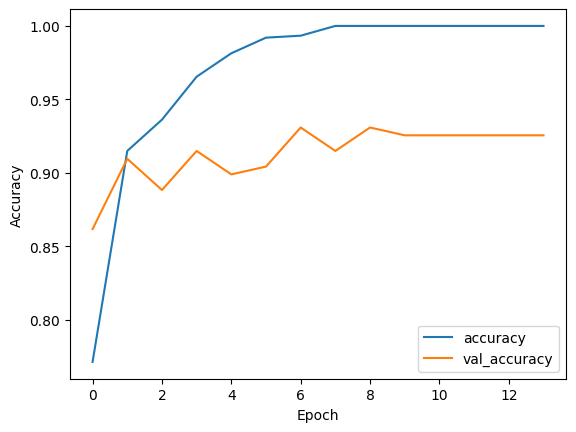

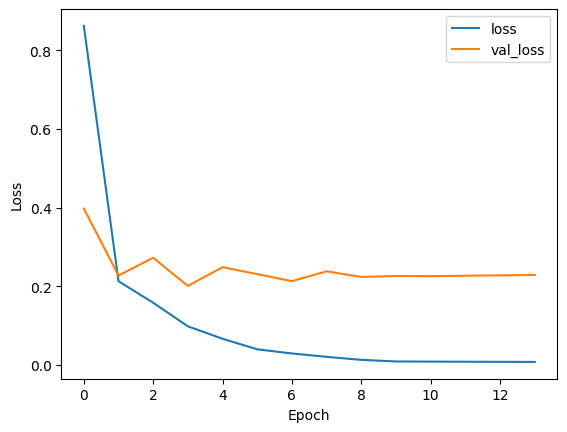


--- Loading best model from checkpoint ---

--- Evaluating model on test data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9098 - loss: 0.2780 - precision_1: 0.9036 - recall_1: 0.8791
Test Loss: 0.2131
Test Accuracy: 0.9309
Test Precision: 0.9398
Test Recall: 0.9070
Test F1 Score (for Class 1 'non cancer'): 0.9231

--- Generating Classification Report and Confusion Matrix ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 979ms/step

--- Classification Report (Scikit-learn) ---
                      precision    recall  f1-score   support

    cancer (Class 0)       0.92      0.95      0.94       102
non cancer (Class 1)       0.94      0.91      0.92        86

            accuracy                           0.93       188
           macro avg       0.93      0.93      0.93       188
        weighted avg       0.93      0.93      0.93       188


--- Confusion Matrix ---


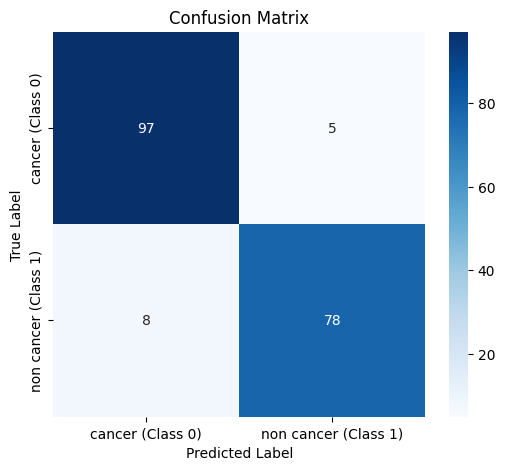

In [2]:
# --- 1. Imports ---
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model

# Imports needed for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 2. Load Data ---
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size for ResNet
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# --- 4. Define and Compile Model (Transfer Learning) ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the ResNet-50 base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

# --- 5. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model_resnet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

# --- 6. Train the Model ---
history = model_resnet50.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# --- 7. Plot Training History ---
print("\n--- Plotting Training History ---")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- 8. Evaluate Model (F1 Score, Report, Confusion Matrix) ---

print("\n--- Loading best model from checkpoint ---")
# Load the weights from the best model saved during training
model_resnet50.load_weights(checkpoint_filepath)

print("\n--- Evaluating model on test data ---")
# Evaluate the model on the test set
# The 'evaluation' list will contain [loss, accuracy, precision, recall]
evaluation = model_resnet50.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")

# Calculate F1 Score from Keras metrics
# NOTE: Keras's default metrics (Precision, Recall) are for class 1.
# In your case (enumerate(['cancer', 'non cancer'])), 
# Class 0 = 'cancer' and Class 1 = 'non cancer'.
# So, this F1 score is for the 'non cancer' class.
precision = evaluation[2]
recall = evaluation[3]
# Add 1e-7 to avoid division by zero
f1_score_keras = 2 * (precision * recall) / (precision + recall + 1e-7) 
print(f"Test F1 Score (for Class 1 'non cancer'): {f1_score_keras:.4f}")


print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions for the test set
y_pred_prob = model_resnet50.predict(X_test)
# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Define target names based on your load_data function
# 0 = 'cancer', 1 = 'non cancer'
target_names = ['cancer (Class 0)', 'non cancer (Class 1)']

print("\n--- Classification Report (Scikit-learn) ---")
# This report shows precision, recall, and F1-score for EACH class
print(classification_report(y_test, y_pred_binary, target_names=target_names))


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# resrnet50wth f1(jst a copy)



In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model

# Load data
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Define and compile the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the DenseNet121 base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_densenet121 = Model(inputs=base_model.input, outputs=predictions)



model_densenet121.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model_densenet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

# Train the model
history = model_densenet121.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()



# VGG19

2025-11-18 15:54:03.745536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763481244.226174      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763481244.333198      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1763481282.752139      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763481282.753124      39 gp

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1763481289.271995     105 service.cc:148] XLA service 0x7fb8b4108620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763481289.273590     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763481289.273614     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763481289.811974     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/24 ━━━━━━━━━━━━━━━━━━━━ 5:52 15s/step - accuracy: 0.7188 - loss: 1.4328 - precision: 0.7200 - recall: 0.9000

I0000 00:00:1763481301.505301     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7413 - loss: 1.6293 - precision: 0.7402 - recall: 0.7355
Epoch 1: val_accuracy improved from -inf to 0.89894, saving model to /kaggle/working/best_model_VGG19.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 999ms/step - accuracy: 0.7428 - loss: 1.6133 - precision: 0.7414 - recall: 0.7372 - val_accuracy: 0.8989 - val_loss: 0.4312 - val_precision: 0.8681 - val_recall: 0.9186 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8484 - loss: 0.6257 - precision: 0.8482 - recall: 0.8474
Epoch 2: val_accuracy did not improve from 0.89894
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8489 - loss: 0.6241 - precision: 0.8487 - recall: 0.8476 - val_accuracy: 0.7819 - val_loss: 1.0398 - val_precision: 0.6800 - val_recall: 0.9884 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8505 - loss: 0.7166 - precision: 0.8158 - recall: 0.8876
Epoch 3: val_accuracy did not improv

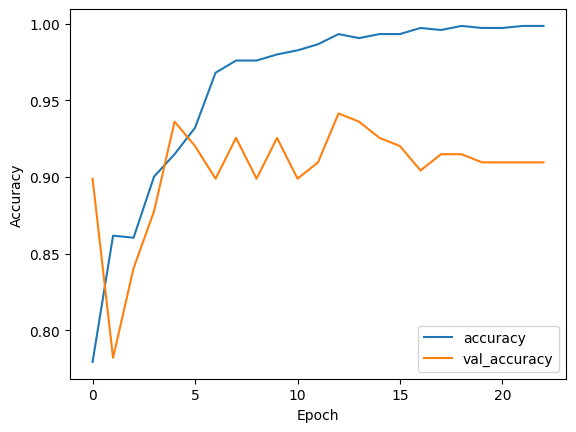

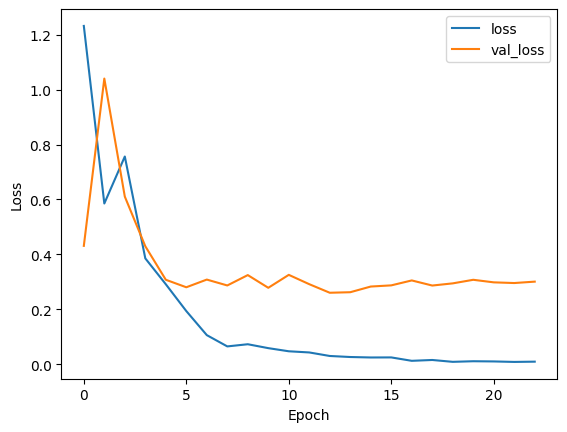


--- Loading best model from checkpoint ---

--- Evaluating model on test data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.9352 - loss: 0.2662 - precision: 0.9550 - recall: 0.8867
Test Loss: 0.2606
Test Accuracy: 0.9415
Test Precision: 0.9518
Test Recall: 0.9186
Test F1 Score (for Class 1 'non cancer'): 0.9349

--- Generating Classification Report and Confusion Matrix ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step

--- Classification Report (Scikit-learn) ---
                      precision    recall  f1-score   support

    cancer (Class 0)       0.93      0.96      0.95       102
non cancer (Class 1)       0.95      0.92      0.93        86

            accuracy                           0.94       188
           macro avg       0.94      0.94      0.94       188
        weighted avg       0.94      0.94      0.94       188


--- Confusion Matrix ---


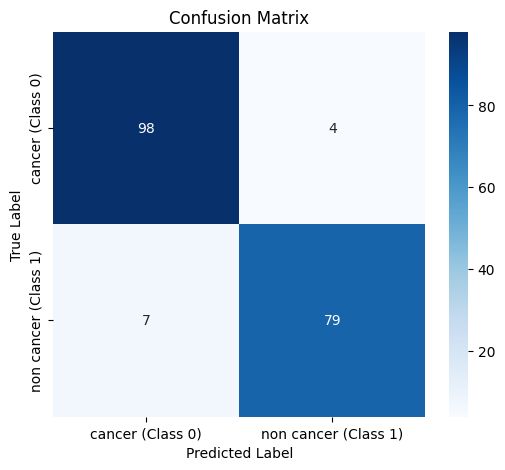

In [1]:
# --- 1. Imports ---
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2,VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model

# Imports needed for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 2. Load Data ---
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# --- 4. Define and Compile Model (VGG19 Transfer Learning) ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
predictions = layers.Dense(1, activation='sigmoid')(x)

model_VGG19 = Model(inputs=base_model.input, outputs=predictions)

model_VGG19.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

# --- 5. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model_VGG19.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

# --- 6. Train the Model ---
history = model_VGG19.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# --- 7. Plot Training History ---
print("\n--- Plotting Training History ---")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- 8. Evaluate Model (F1 Score, Report, Confusion Matrix) ---

print("\n--- Loading best model from checkpoint ---")
# Load the weights from the best model saved during training
model_VGG19.load_weights(checkpoint_filepath)

print("\n--- Evaluating model on test data ---")
# Evaluate the model on the test set
# The 'evaluation' list will contain [loss, accuracy, precision, recall]
evaluation = model_VGG19.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")

# Calculate F1 Score from Keras metrics
# NOTE: Keras's default metrics (Precision, Recall) are for class 1.
# In your case (enumerate(['cancer', 'non cancer'])), 
# Class 0 = 'cancer' and Class 1 = 'non cancer'.
# So, this F1 score is for the 'non cancer' class.
precision = evaluation[2]
recall = evaluation[3]
# Add 1e-7 to avoid division by zero
f1_score_keras = 2 * (precision * recall) / (precision + recall + 1e-7) 
print(f"Test F1 Score (for Class 1 'non cancer'): {f1_score_keras:.4f}")


print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions for the test set
y_pred_prob = model_VGG19.predict(X_test)
# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Define target names based on your load_data function
# 0 = 'cancer', 1 = 'non cancer'
target_names = ['cancer (Class 0)', 'non cancer (Class 1)']

print("\n--- Classification Report (Scikit-learn) ---")
# This report shows precision, recall, and F1-score for EACH class
print(classification_report(y_test, y_pred_binary, target_names=target_names))


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EfficientNetB2

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


E0000 00:00:1763483017.998010     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763483018.184354     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7682 - loss: 0.4953 - precision_5: 0.7874 - recall_5: 0.7182

E0000 00:00:1763483036.162957     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763483036.323732     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.7717 - loss: 0.4903 - precision_5: 0.7903 - recall_5: 0.7233

E0000 00:00:1763483058.850393     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763483059.030733     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.90957, saving model to /kaggle/working/best_model_efficient.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7750 - loss: 0.4857 - precision_5: 0.7928 - recall_5: 0.7280 - val_accuracy: 0.9096 - val_loss: 0.2197 - val_precision_5: 0.8632 - val_recall_5: 0.9535 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9236 - loss: 0.1771 - precision_5: 0.9110 - recall_5: 0.9351
Epoch 2: val_accuracy improved from 0.90957 to 0.91489, saving model to /kaggle/working/best_model_efficient.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9240 - loss: 0.1772 - precision_5: 0.9114 - recall_5: 0.9353 - val_accuracy: 0.9149 - val_loss: 0.1904 - val_precision_5: 0.9070 - val_recall_5: 0.9070 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9516 - loss: 0.1229 - precision_5: 0.9532 - recall_5: 0.9489
Epoch 3: val_accuracy did not improve from 0.91489
24/24 ━━━

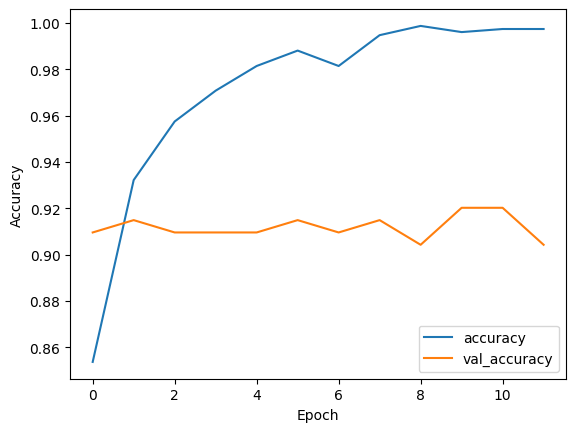

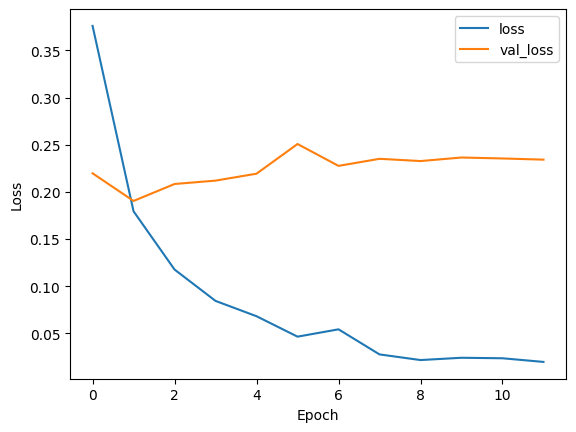


--- Loading best model from checkpoint ---

--- Evaluating model on test data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9157 - loss: 0.2885 - precision_5: 0.8786 - recall_5: 0.9370
Test Loss: 0.2365
Test Accuracy: 0.9202
Test Precision: 0.8817
Test Recall: 0.9535
Test F1 Score (for Class 1 'non cancer'): 0.9162

--- Generating Classification Report and Confusion Matrix ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step

--- Classification Report (Scikit-learn) ---
                      precision    recall  f1-score   support

    cancer (Class 0)       0.96      0.89      0.92       102
non cancer (Class 1)       0.88      0.95      0.92        86

            accuracy                           0.92       188
           macro avg       0.92      0.92      0.92       188
        weighted avg       0.92      0.92      0.92       188


--- Confusion Matrix ---


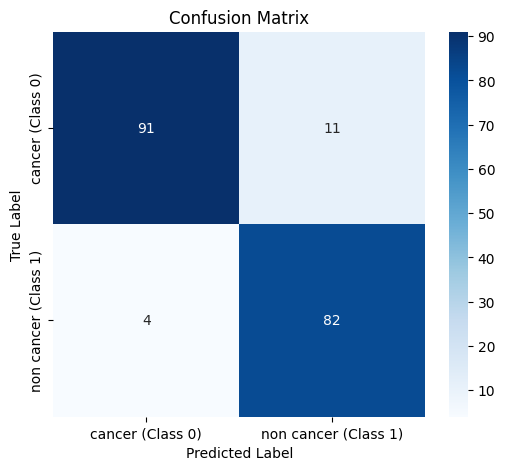

In [9]:
# --- 1. Imports ---
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model

# Imports needed for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 2. Load Data ---
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# --- 4. Define and Compile Model (EfficientNetB2 Transfer Learning) ---
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)

model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

# --- 5. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model_efficient.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

# --- 6. Train the Model ---
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# --- 7. Plot Training History ---
print("\n--- Plotting Training History ---")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- 8. Evaluate Model (F1 Score, Report, Confusion Matrix) ---

print("\n--- Loading best model from checkpoint ---")
# Load the weights from the best model saved during training
model_EfficientNetB2.load_weights(checkpoint_filepath)

print("\n--- Evaluating model on test data ---")
# Evaluate the model on the test set
# The 'evaluation' list will contain [loss, accuracy, precision, recall]
evaluation = model_EfficientNetB2.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")

# Calculate F1 Score from Keras metrics
# NOTE: Keras's default metrics (Precision, Recall) are for class 1.
# In your case (enumerate(['cancer', 'non cancer'])), 
# Class 0 = 'cancer' and Class 1 = 'non cancer'.
# So, this F1 score is for the 'non cancer' class.
precision = evaluation[2]
recall = evaluation[3]
# Add 1e-7 to avoid division by zero
f1_score_keras = 2 * (precision * recall) / (precision + recall + 1e-7) 
print(f"Test F1 Score (for Class 1 'non cancer'): {f1_score_keras:.4f}")


print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions for the test set
y_pred_prob = model_EfficientNetB2.predict(X_test)
# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Define target names based on your load_data function
# 0 = 'cancer', 1 = 'non cancer'
target_names = ['cancer (Class 0)', 'non cancer (Class 1)']

print("\n--- Classification Report (Scikit-learn) ---")
# This report shows precision, recall, and F1-score for EACH class
print(classification_report(y_test, y_pred_binary, target_names=target_names))


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# DensNet121

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.5513 - loss: 2.2743 - precision_4: 0.5478 - recall_4: 0.5622
Epoch 1: val_accuracy improved from -inf to 0.76064, saving model to /kaggle/working/best_model_densenet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5549 - loss: 2.2479 - precision_4: 0.5510 - recall_4: 0.5652 - val_accuracy: 0.7606 - val_loss: 0.5702 - val_precision_4: 0.8868 - val_recall_4: 0.5465 - learning_rate: 0.0010
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7881 - loss: 0.4994 - precision_4: 0.8300 - recall_4: 0.7449
Epoch 2: val_accuracy improved from 0.76064 to 0.82447, saving model to /kaggle/working/best_model_densenet.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7897 - loss: 0.4950 - precision_4: 0.8281 - recall_4: 0.7488 - val_accuracy: 0.8245 - val_loss: 0.4487 - val_precision_4: 0.8354 - val_recall_4: 0.7674 - learning_rate: 0.0010
Epoch 3/50


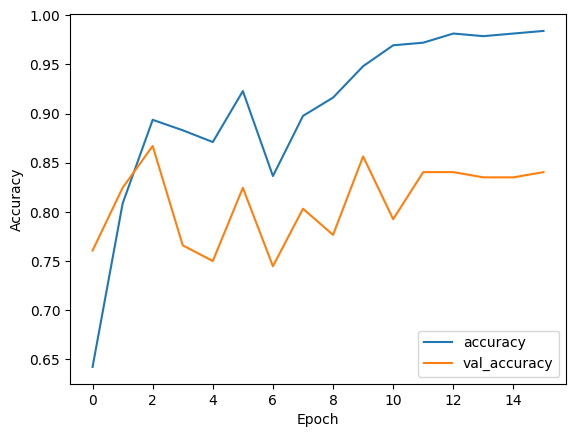

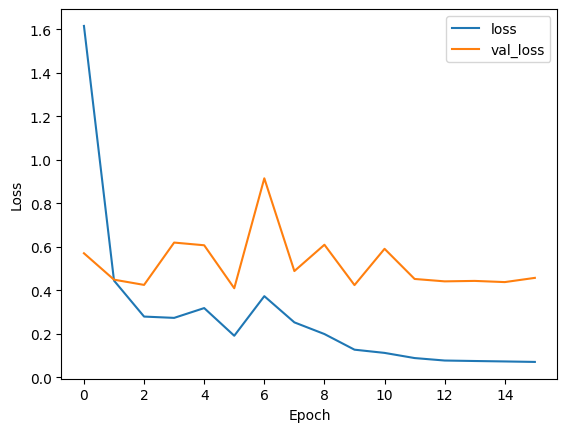


--- Loading best model from checkpoint ---

--- Evaluating model on test data ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8340 - loss: 0.4789 - precision_4: 0.7940 - recall_4: 0.8348
Test Loss: 0.4247
Test Accuracy: 0.8670
Test Precision: 0.8427
Test Recall: 0.8721
Test F1 Score (for Class 1 'non cancer'): 0.8571

--- Generating Classification Report and Confusion Matrix ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step

--- Classification Report (Scikit-learn) ---
                      precision    recall  f1-score   support

    cancer (Class 0)       0.89      0.86      0.88       102
non cancer (Class 1)       0.84      0.87      0.86        86

            accuracy                           0.87       188
           macro avg       0.87      0.87      0.87       188
        weighted avg       0.87      0.87      0.87       188


--- Confusion Matrix ---


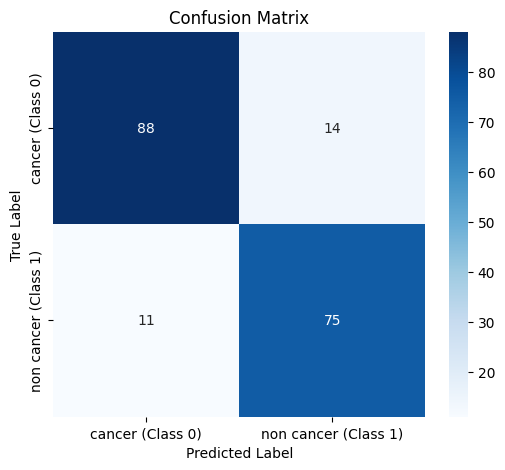

In [8]:
# --- 1. Imports ---
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model

# Imports needed for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 2. Load Data ---
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/kaggle/input/new-oral-cancer/OC"
images, labels = load_data(folder_path)

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# --- 4. Define and Compile Model (DenseNet121 Transfer Learning) ---
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the DenseNet121 base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_densenet121 = Model(inputs=base_model.input, outputs=predictions)

model_densenet121.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

# --- 5. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = '/kaggle/working/best_model_densenet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

# --- 6. Train the Model ---
history = model_densenet121.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# --- 7. Plot Training History ---
print("\n--- Plotting Training History ---")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- 8. Evaluate Model (F1 Score, Report, Confusion Matrix) ---

print("\n--- Loading best model from checkpoint ---")
# Load the weights from the best model saved during training
model_densenet121.load_weights(checkpoint_filepath)

print("\n--- Evaluating model on test data ---")
# Evaluate the model on the test set
# The 'evaluation' list will contain [loss, accuracy, precision, recall]
evaluation = model_densenet121.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")
print(f"Test Precision: {evaluation[2]:.4f}")
print(f"Test Recall: {evaluation[3]:.4f}")

# Calculate F1 Score from Keras metrics
# NOTE: Keras's default metrics (Precision, Recall) are for class 1.
# In your case (enumerate(['cancer', 'non cancer'])), 
# Class 0 = 'cancer' and Class 1 = 'non cancer'.
# So, this F1 score is for the 'non cancer' class.
precision = evaluation[2]
recall = evaluation[3]
# Add 1e-7 to avoid division by zero
f1_score_keras = 2 * (precision * recall) / (precision + recall + 1e-7) 
print(f"Test F1 Score (for Class 1 'non cancer'): {f1_score_keras:.4f}")


print("\n--- Generating Classification Report and Confusion Matrix ---")
# Get predictions for the test set
y_pred_prob = model_densenet121.predict(X_test)
# Convert probabilities to binary classes (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Define target names based on your load_data function
# 0 = 'cancer', 1 = 'non cancer'
target_names = ['cancer (Class 0)', 'non cancer (Class 1)']

print("\n--- Classification Report (Scikit-learn) ---")
# This report shows precision, recall, and F1-score for EACH class
print(classification_report(y_test, y_pred_binary, target_names=target_names))


print("\n--- Confusion Matrix ---")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()